# Compare the forward model from 2 atmospheric models

In [2]:
import os, glob
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta

from acrg.name import name
from acrg.obs import get_obs

import apo_funcs, apo_plot_info

In [3]:
year = 2015

colors = {'carbontracker': 'dodgerblue',
          'NAME': 'forestgreen',
          'obs': 'magenta'}

start_dates = {month: datetime(year, month, 1) for month in range(1, 13)}
end_dates = {month: start_date + relativedelta(months=1, seconds=-1) for month, start_date in start_dates.items()}

## Import Carbon Tracker model

In [4]:
file_path = os.path.join('/user', 'work', 'vf20487', 'Data')
file_name = glob.glob(os.path.join(file_path, f'co2_wao*.nc'))[0]
file_name

'/user/work/vf20487/Data/co2_wao_surface-insitu_13_allvalid.nc'

In [5]:
carbontrack_data = name.open_ds(file_name)
carbontrack_data

<xarray.Dataset>
Dimensions:                                 (obs: 48352,
                                             calendar_components: 6,
                                             dim_concerns: 6, mip_nmodels: 17,
                                             nmembers: 5)
Dimensions without coordinates: obs, calendar_components, dim_concerns,
                                mip_nmodels, nmembers
Data variables: (12/40)
    time                                    (obs) datetime64[ns] 2007-10-31T1...
    start_time                              (obs) datetime64[ns] 2007-10-31T1...
    midpoint_time                           (obs) datetime64[ns] 2007-10-31T1...
    datetime                                (obs) |S100 b'2007-10-31T15:30:00...
    time_decimal                            (obs) float64 2.008e+03 ... 2.02e+03
    time_components                         (obs, calendar_components) float64 ...
    ...                                      ...
    modelsamplesmean                        (obs) float32 0.0003686 ... 9.969...
    modelsamplesmean_forecast               (obs) float32 9.969e+36 ... 9.969...
    modelsamplesstandarddeviation           (obs) float32 1.836e-05 ... 9.969...
    modelsamplesstandarddeviation_forecast  (obs) float32 9.969e+36 ... 9.969...
    modelsamplesensemble                    (obs, nmembers) float32 0.0003686...
    modelsamplesensemble_forecast           (obs, nmembers) float32 9.969e+36...
Attributes: (12/101)
    site_code:                                    WAO
    site_name:                                    Weybourne, Norfolk
    site_country:                                 United Kingdom
    site_country_flag:                            UNKG0001.GIF
    site_latitude:                                52.9502
    site_longitude:                               1.1219
    ...                                           ...
    Caution:                                      ===========================...
    History:                                      \nOriginal observation file...
    CTDAS_info:                                   Simulated values added from...
    CTDAS_startdate:                              2007-10-27
    CTDAS_enddate:                                2022-01-30
    original_file:                                /mnt/beegfs/user/gkoren/ctd...

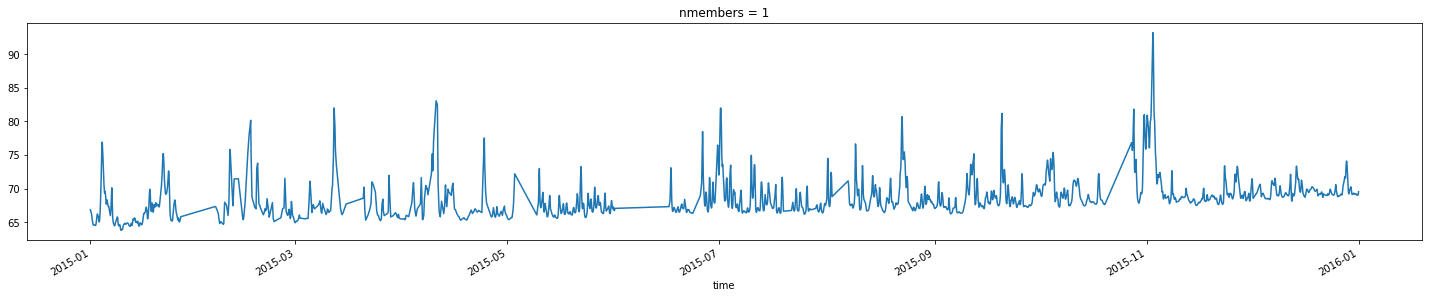

In [6]:
nmembers = {'background': 0, 'fossil': 1, 'biosphere': 2, 'ocean': 3, 'fires': 4}

carbontrack_ts = xr.DataArray(data=carbontrack_data['modelsamplesensemble'].values,
                              coords={'time': carbontrack_data.start_time.values,
                                      'nmembers': carbontrack_data.nmembers})
carbontrack_ff = carbontrack_ts.sel(nmembers=nmembers['fossil'])*1e6
ff_plot = carbontrack_ff.sel(time=str(year)).plot(figsize=(25, 4))


## Import NAME model

In [7]:
name_ts_all = apo_funcs.get_timeseries(sites=['WAO'], year=year, sources=['ff', 'bio_orchidee', 'ocean', 'bc'])

Finding timeseries for WAO
ff: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ff_timeseries_2015.nc']
bio_orchidee: ['/user/work/vf20487/Timeseries/o2_co2/WAO_bio_orchidee_timeseries_2015.nc']
ocean: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ocean_timeseries_2015.nc']
bc: ['/user/work/vf20487/Timeseries/o2_co2/WAO_bc_timeseries_2015.nc']
renaming co2-gpp_bio_orchidee: co2_gpp_bio_orchidee
renaming co2-rtot_bio_orchidee: co2_rtot_bio_orchidee

Data variables:
['co2_ff', 'o2_ff', 'co2_gpp_bio_orchidee', 'co2_rtot_bio_orchidee', 'o2_ocean_nemo', 'n2_ocean_nemo', 'o2_ocean_ecco', 'o2_ocean_jena', 'co2_ocean_nemo', 'apo_bc', 'co2_bc', 'o2_bc']


## Plot both

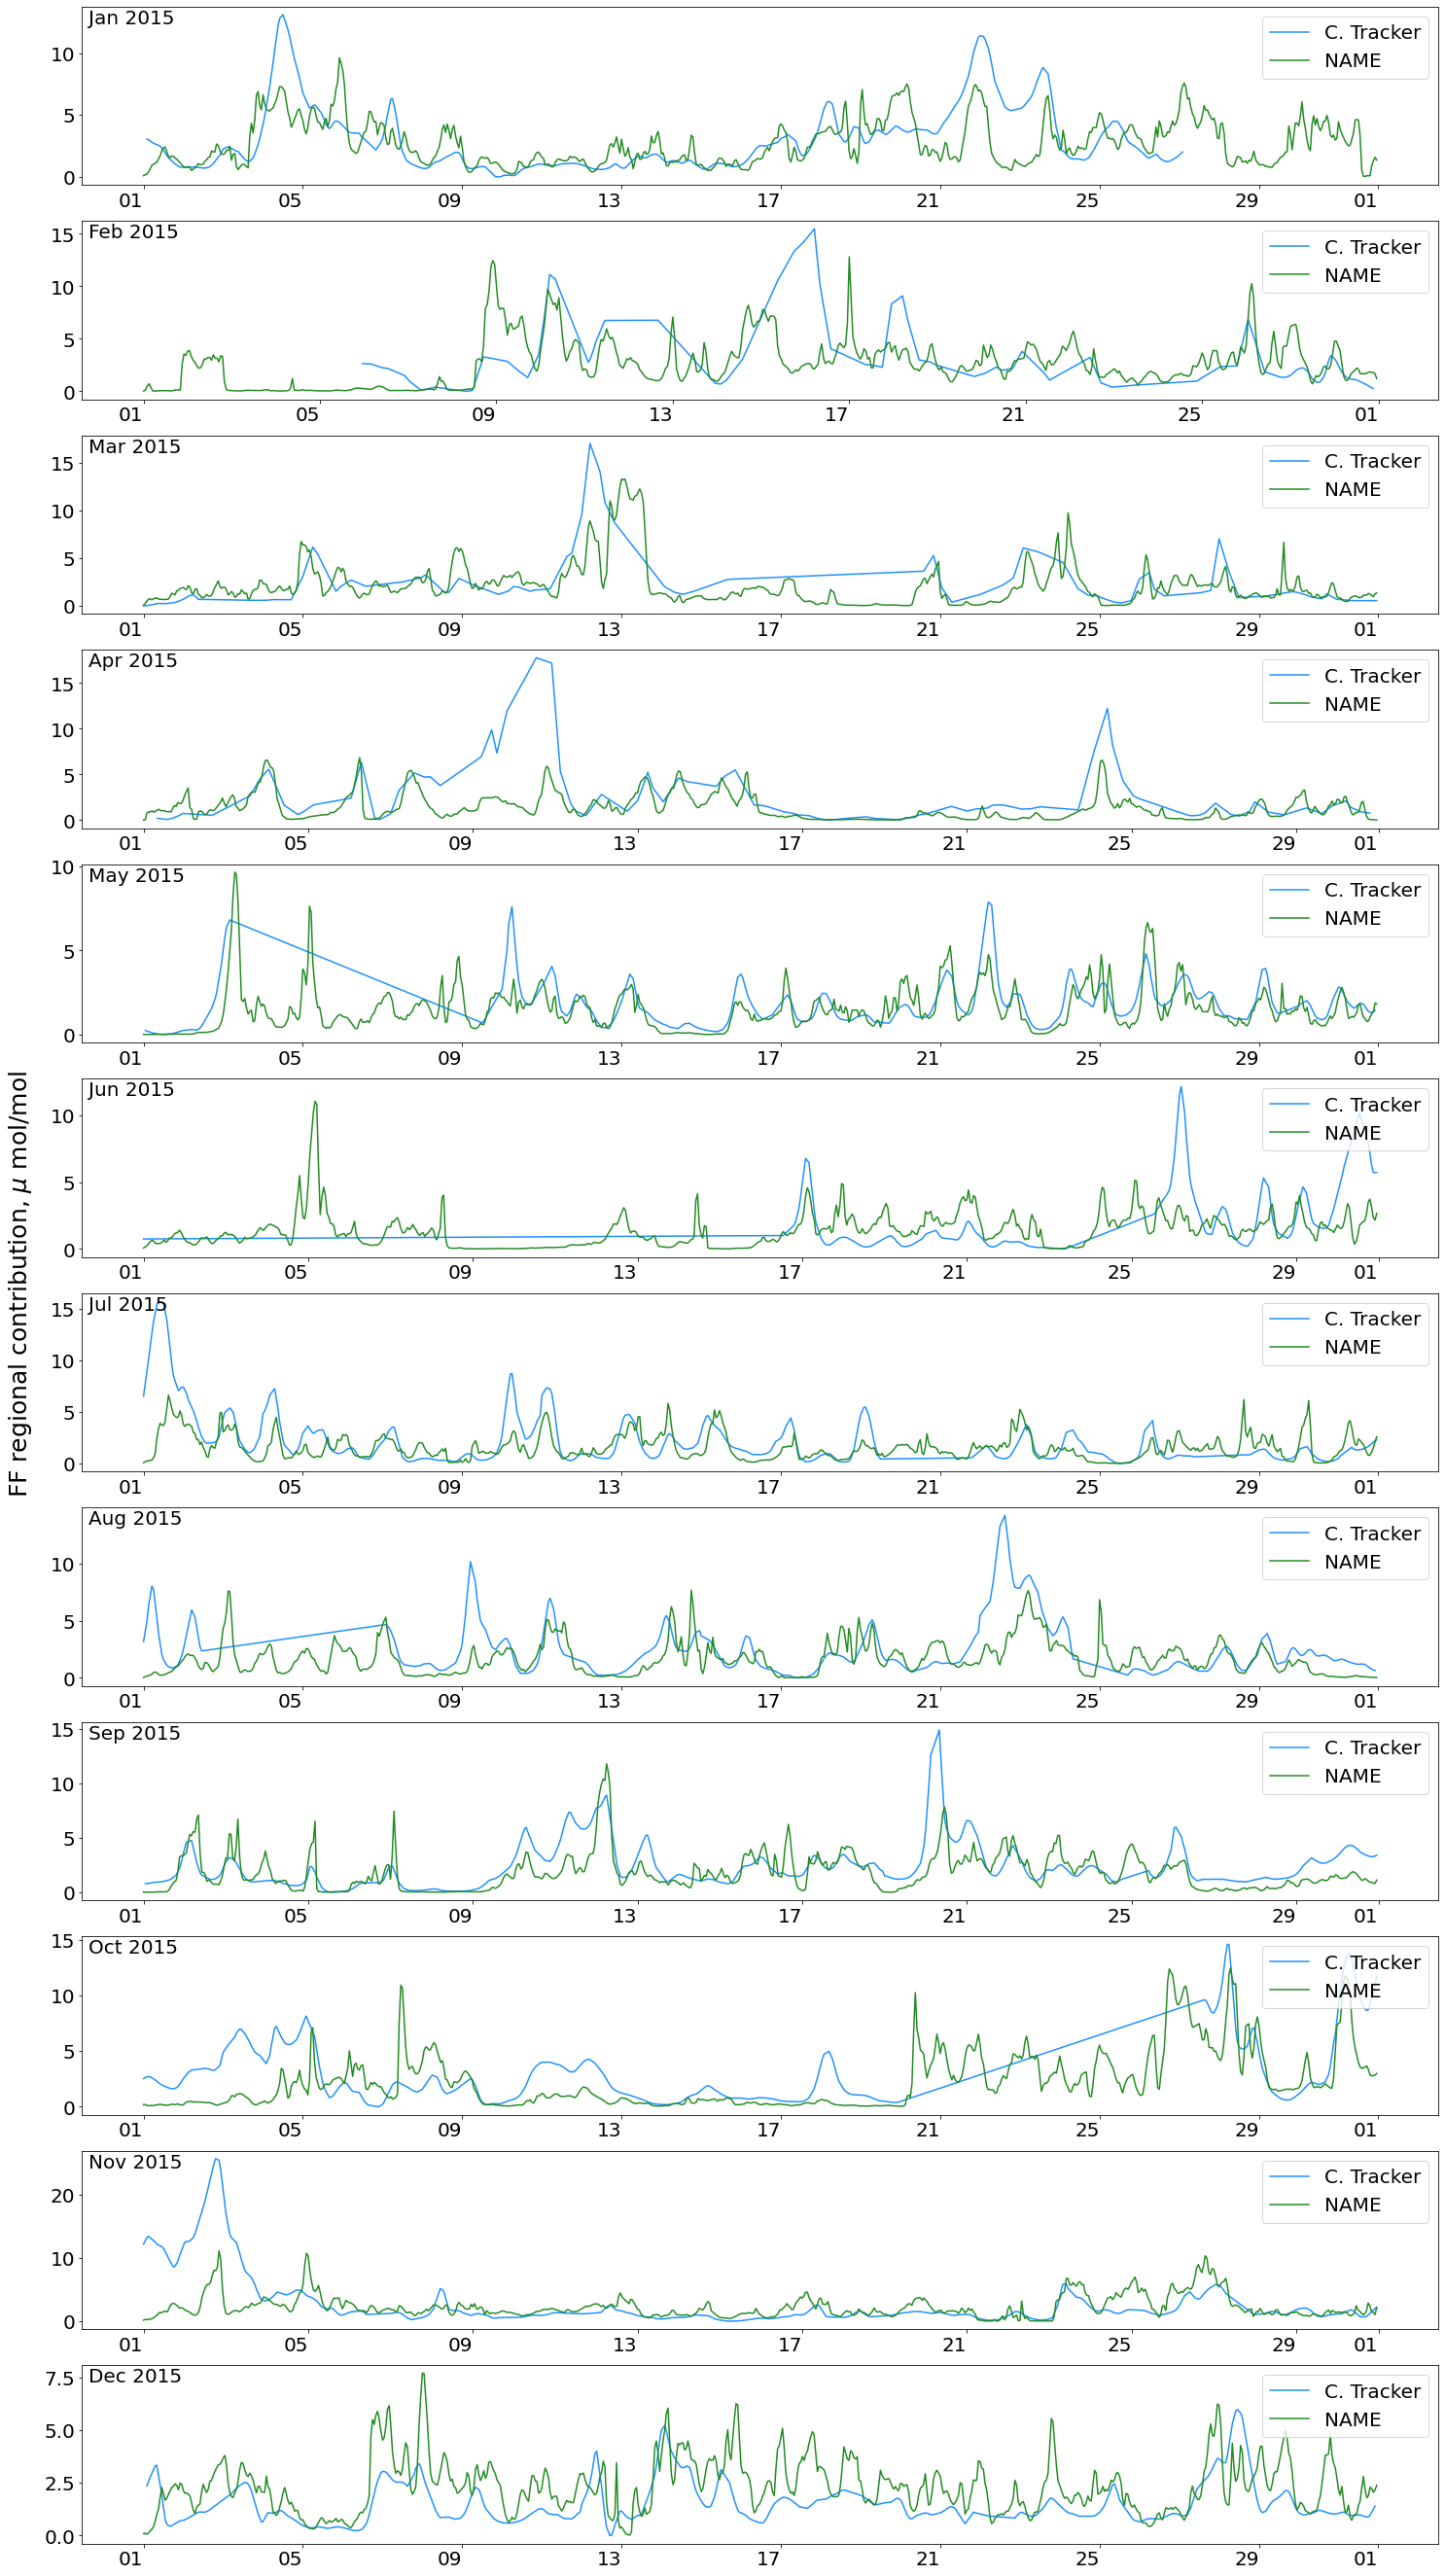

In [8]:
fig, axes = plt.subplots(ncols=1, nrows=12, figsize=(25, 4*12))

for month, start in start_dates.items():
    ax = axes.flat[month-1]
    model_month = carbontrack_ff.sel(time=slice(start, end_dates[month]))
    if len(model_month)>0:
        model_month = model_month - model_month.min()
        model_month.plot(ax=ax, color=colors['carbontracker'], label='C. Tracker')
    name_ts_all['WAO']['co2_ff'].sel(time=slice(start, end_dates[month])).plot(ax=ax, color=colors['NAME'], label='NAME')

    ylabel = ax.set_ylabel('')
    xlabel = ax.set_xlabel('')

    legend = ax.legend(loc='upper right',  fontsize=20)

myFmt = mdates.DateFormatter('%d')
[ax.xaxis.set_major_formatter(myFmt) for ax in axes]
ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
# ticks = [axes[ii].xaxis.set_ticklabels([]) for ii in range(len(axes)) if ii!=11]
text = [axes[mm].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[mm].transAxes, va='top', fontsize=20)
        for mm, month in enumerate(range(1, 13))]
ylabel = fig.text(0.09, 0.5, r'FF regional contribution, $\mu$ mol/mol', va='center', ha='center', rotation='vertical', fontsize=25)

# Calculate total CO2 to compare with obs

## Import the obs

In [9]:
co2_obs = get_obs(['WAO'], 'CO2', f'{year}-01-01', f'{year+1}-01-01', keep_missing=True)['WAO'][0].mf

Assuming status flag = 0 for all sites
Getting CO2 data for WAO...
... reading /group/chemistry/acrg/obs/WAO/UEA-NDIR_WAO_20100519_CO2-20211221.nc
... slicing from 2015-01-01 00:00:00 to 2015-12-31 23:59:59.999999999


## Combine model components

In [10]:
name_ts_total = name_ts_all['WAO'].co2_ff + name_ts_all['WAO'].co2_gpp_bio_orchidee + \
                name_ts_all['WAO'].co2_rtot_bio_orchidee + name_ts_all['WAO'].co2_ocean_nemo + \
                name_ts_all['WAO'].co2_bc

carbontrack_ts_total = carbontrack_ts.sum(dim='nmembers').sel(time=str(year))*1e6

## Plot all

Saving to: /user/work/vf20487/Figures/CO2_NAMEvsCarbonTracker_2015.png


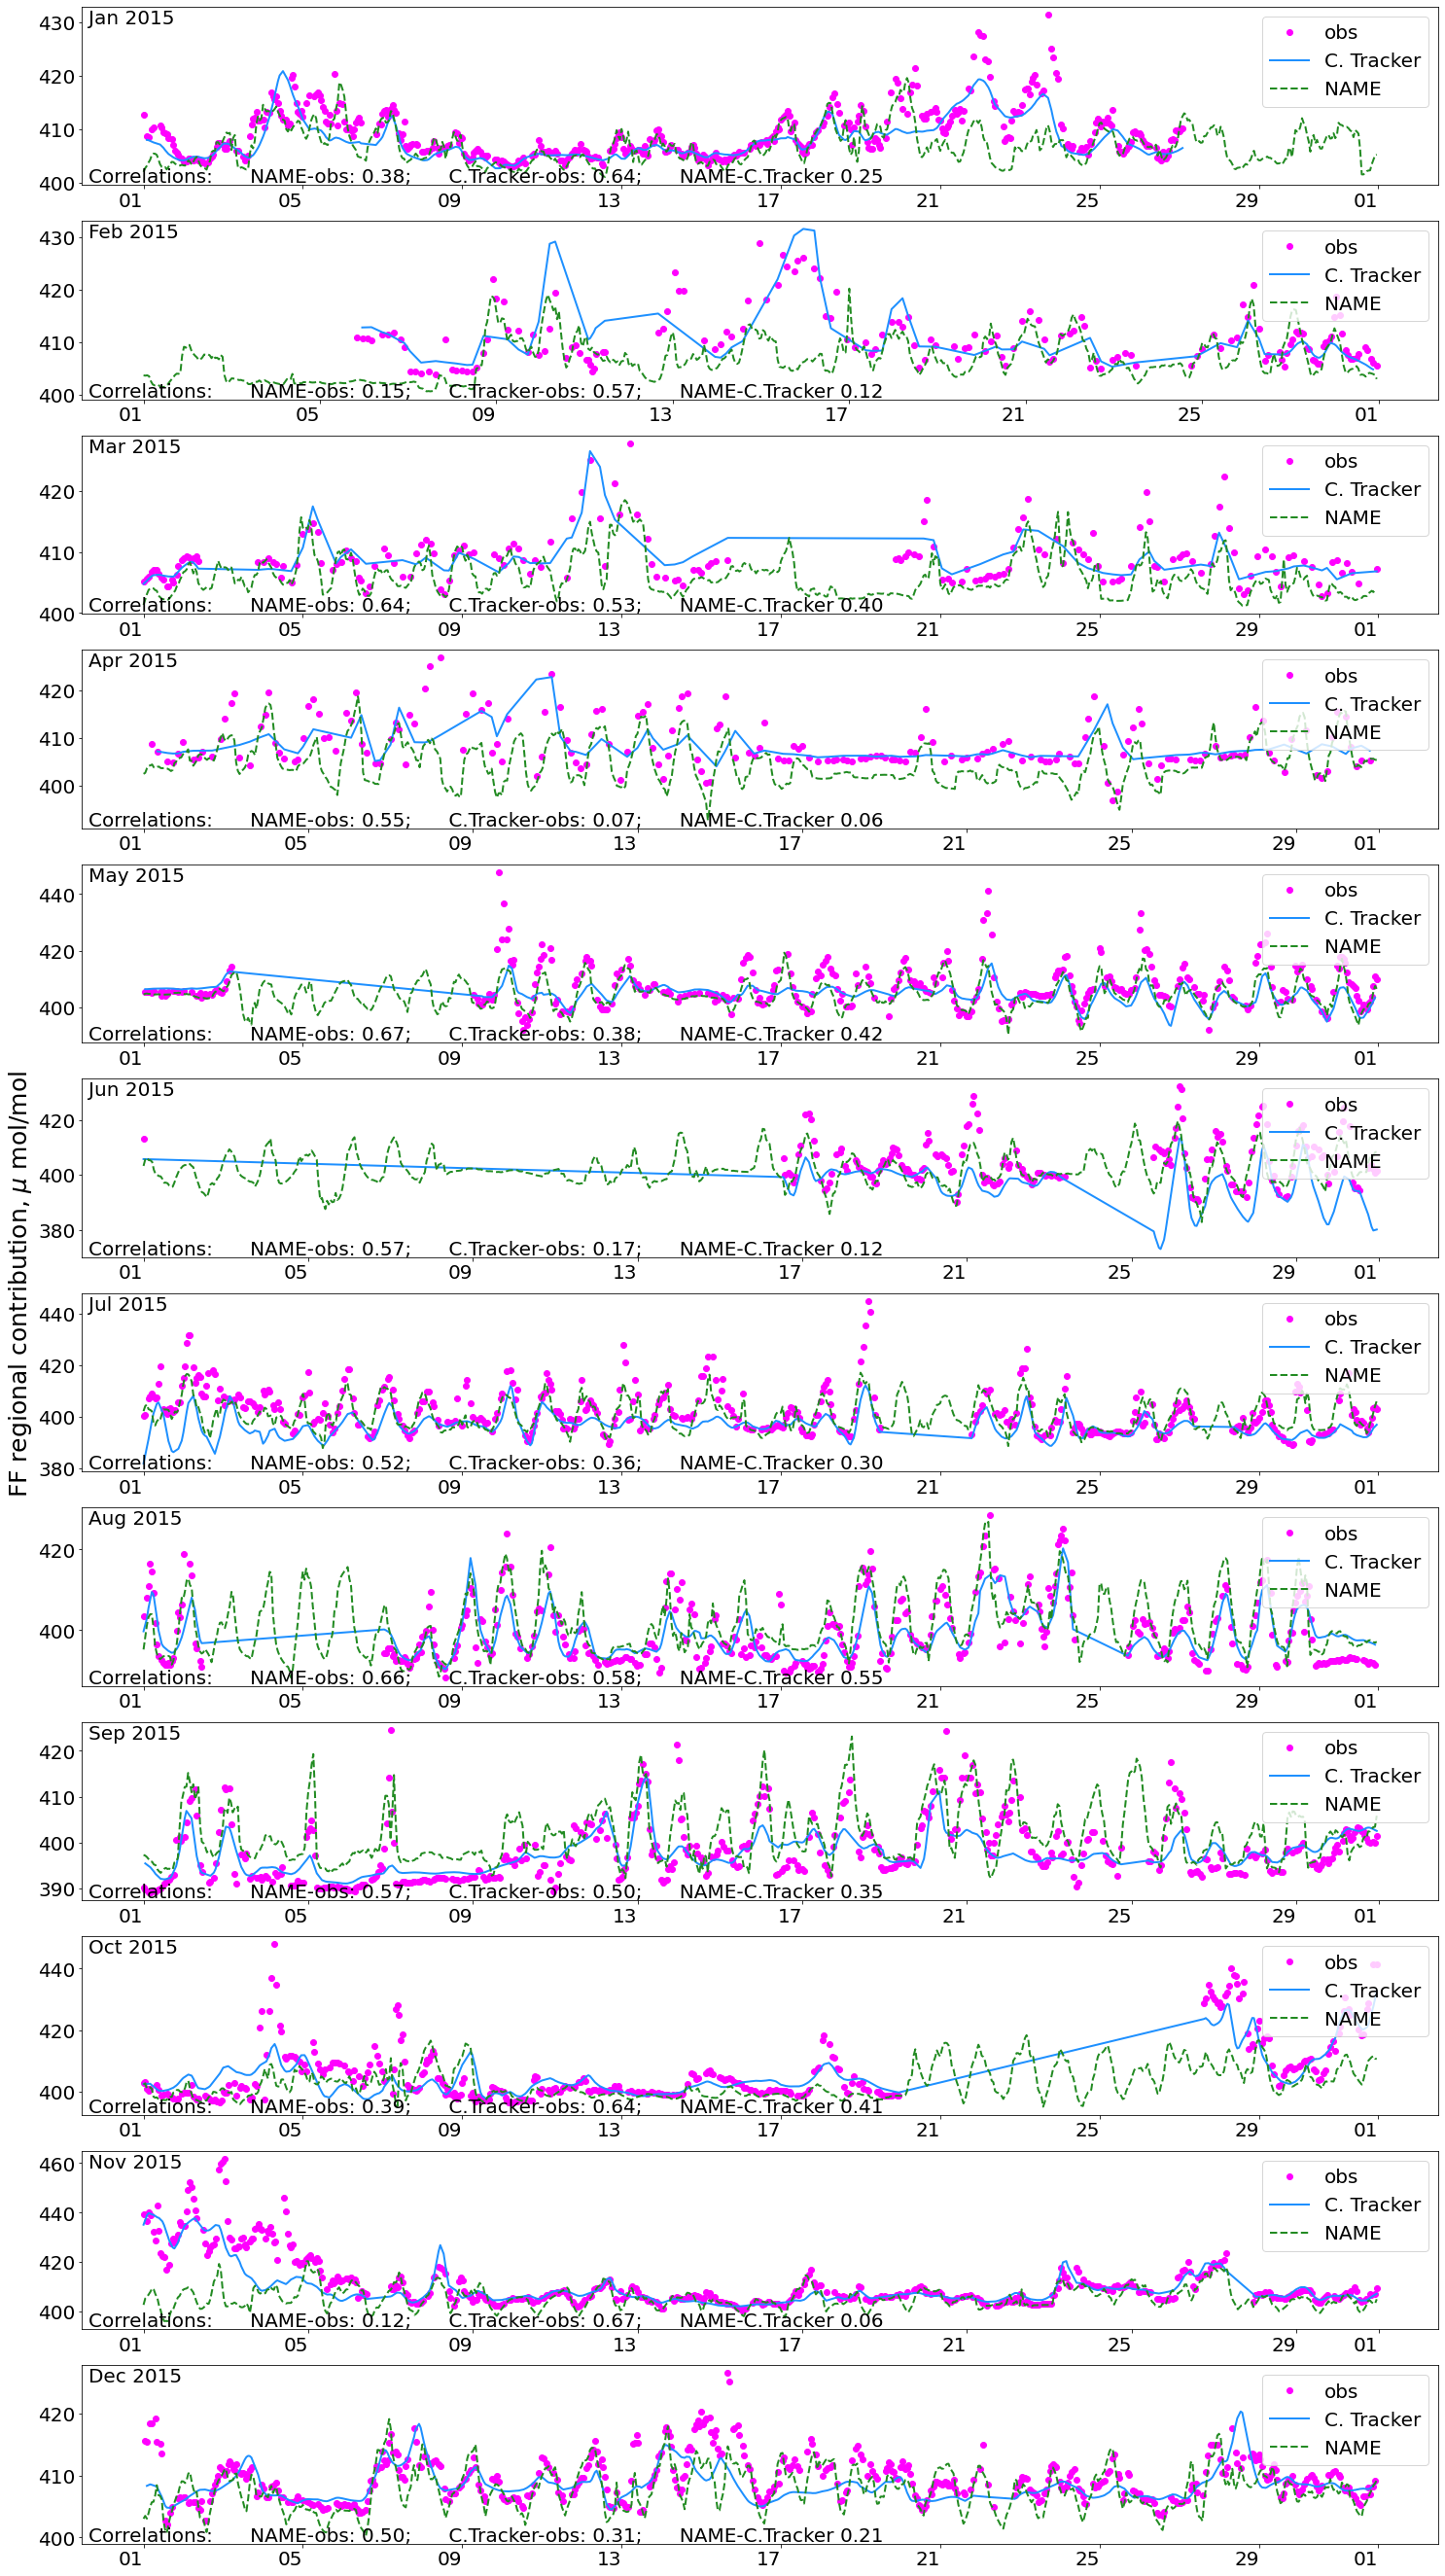

In [16]:
fig, axes = plt.subplots(ncols=1, nrows=12, figsize=(25, 4*12))

for month, start in start_dates.items():
    ax = axes.flat[month-1]
    obs_plot = co2_obs.sel(time=slice(start, end_dates[month])).plot(ax=ax, marker='o', ls='none',
                                                                     color=colors['obs'], label='obs')
    name_plot = name_ts_total.sel(time=slice(start, end_dates[month])).plot(ax=ax, color=colors['NAME'], lw=2, ls='--', label='NAME')

    # check that there is carbon tracker data for the month and adjust the baseline
    carbontrack_ts_month = carbontrack_ts_total.sel(time=slice(start, end_dates[month]))
    if len(carbontrack_ts_month)>0:
        carbontrack_tsmonth = carbontrack_ts_month - carbontrack_ts_month.min()
        carbontrack_plot = carbontrack_ts_month.plot(ax=ax, color=colors['carbontracker'], lw=2, label='C. Tracker')

        # label the correlation between each model and the obs, and each other
        correlations = {'name-obs': float(xr.corr(name_ts_total.sel(time=slice(start, end_dates[month])), co2_obs.sel(time=slice(start, end_dates[month]))))**2,
                        'ctrack-obs': float(xr.corr(carbontrack_ts_month, co2_obs.sel(time=slice(start, end_dates[month]))))**2,
                        'name-ctrack': float(xr.corr(name_ts_total.sel(time=slice(start, end_dates[month])), carbontrack_ts_month))**2
        }
        corr_text = ax.text(0.005, 0.015, f'Correlations:      ' +
                                        f'NAME-obs: {correlations["name-obs"]:.2f};      ' +
                                        f'C.Tracker-obs: {correlations["ctrack-obs"]:.2f};      ' +
                                        f'NAME-C.Tracker {correlations["name-ctrack"]:.2f}',
                            transform=ax.transAxes, fontsize=20)

    ylabel = ax.set_ylabel('')
    xlabel = ax.set_xlabel('')

    legend = ax.legend(loc='upper right',  fontsize=20)


myFmt = mdates.DateFormatter('%d')
[ax.xaxis.set_major_formatter(myFmt) for ax in axes]
ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
# ticks = [axes[ii].xaxis.set_ticklabels([]) for ii in range(len(axes)) if ii!=11]
text = [axes[mm].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[mm].transAxes, va='top', fontsize=20)
        for mm, month in enumerate(range(1, 13))]
ylabel = fig.text(0.09, 0.5, r'FF regional contribution, $\mu$ mol/mol', va='center', ha='center', rotation='vertical', fontsize=25)

filename = os.path.join('/user', 'work', 'vf20487', 'Figures', f'CO2_NAMEvsCarbonTracker_{year}.png')
print(f'Saving to: {filename}')
# fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

## Compare the correlations

Check the correlation between each model and the observations and each other

In [12]:
correlations = {'name-obs': xr.corr(name_ts_total, co2_obs),
                'ctrack-obs': xr.corr(carbontrack_ts_total, co2_obs),
                'name-ctrack': xr.corr(name_ts_total, carbontrack_ts_total)
}

print(f'{year} Correlations:')
print_corr = [print(f'   {comparison}: {correlation}') for comparison, correlation in correlations.items()]

2015 Correlations:
   name-obs: <xarray.DataArray ()>
array(0.69494757)
   ctrack-obs: <xarray.DataArray ()>
array(0.75126406)
   name-ctrack: <xarray.DataArray ()>
array(0.59864806)
